In [100]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os
import numpy as np

In [101]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

In [102]:
def get_training_data(data_dir):
    data = []
    labels = ['PNEUMONIA', 'NORMAL']  # Ensure casing matches folder names!
    img_size = 150

    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)

        if not os.path.exists(path):
            print("❌ Path not found:", path)
            continue

        for img in os.listdir(path):
            img_path = os.path.join(path, img)
            try:
                img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img_arr is None:
                    print("⚠️ Failed to load:", img_path)
                    continue
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print("⚠️ Error loading:", img_path, e)

    features = np.array([f for f, l in data])
    targets  = np.array([l for f, l in data])

    return features, targets


# Load properly
x_train, y_train = get_training_data(r'D:\datasets\chest_xray\chest_xray\train')
x_test,  y_test  = get_training_data(r'D:\datasets\chest_xray\chest_xray\test')
x_val,   y_val   = get_training_data(r'D:\datasets\chest_xray\chest_xray\val')

print("Train:", x_train.shape, y_train.shape)
print("Val:", x_val.shape, y_val.shape)
print("Test:", x_test.shape, y_test.shape)


⚠️ Failed to load: D:\datasets\chest_xray\chest_xray\train\PNEUMONIA\.DS_Store
⚠️ Failed to load: D:\datasets\chest_xray\chest_xray\train\NORMAL\.DS_Store
⚠️ Failed to load: D:\datasets\chest_xray\chest_xray\val\PNEUMONIA\.DS_Store
⚠️ Failed to load: D:\datasets\chest_xray\chest_xray\val\NORMAL\.DS_Store
Train: (5216, 150, 150) (5216,)
Val: (16, 150, 150) (16,)
Test: (624, 150, 150) (624,)


<Axes: ylabel='count'>

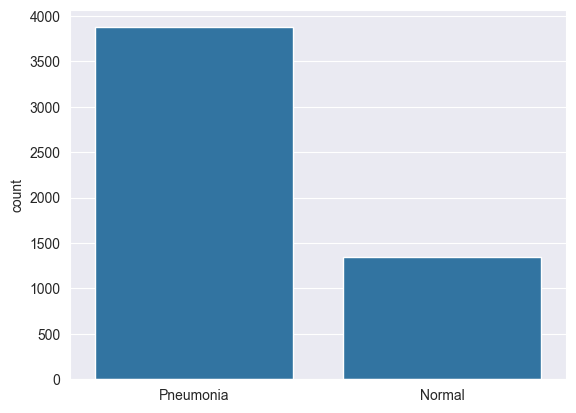

In [103]:
l = ["Pneumonia" if label == 0 else "Normal" for label in y_train]

import seaborn as sns
sns.set_style('darkgrid')
sns.countplot(x=l)


Text(0.5, 1.0, 'NORMAL')

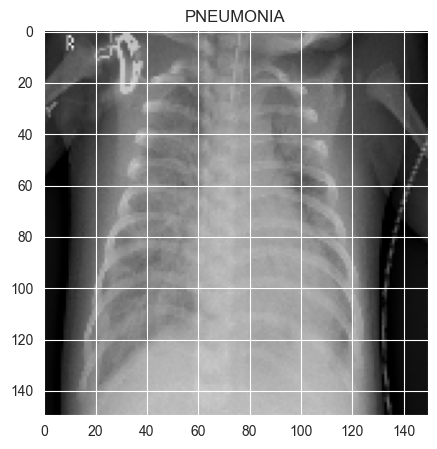

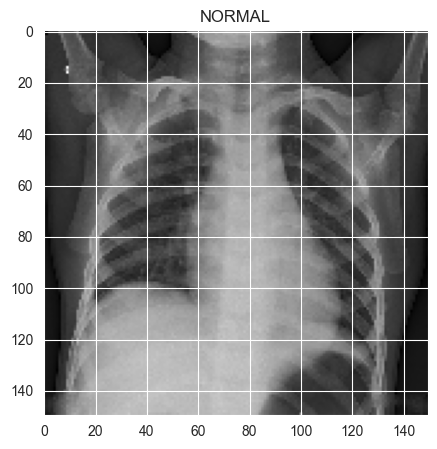

In [104]:
# Show first image
plt.figure(figsize=(5,5))
plt.imshow(x_train[0].squeeze(), cmap='gray')   # squeeze removes the extra channel dimension
plt.title(labels[y_train[0]])

# Show last image
plt.figure(figsize=(5,5))
plt.imshow(x_train[-1].squeeze(), cmap='gray')
plt.title(labels[y_train[-1]])


In [105]:
import numpy as np

# Convert lists to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

x_val   = np.array(x_val)
y_val   = np.array(y_val)

x_test  = np.array(x_test)
y_test  = np.array(y_test)

# Normalize
x_train = x_train.astype("float32") / 255.0
x_val   = x_val.astype("float32")   / 255.0
x_test  = x_test.astype("float32")  / 255.0

# Reshape for CNN
x_train = np.expand_dims(x_train, axis=-1)
x_val   = np.expand_dims(x_val, axis=-1)
x_test  = np.expand_dims(x_test, axis=-1)

print("Train:", x_train.shape, y_train.shape)
print("Val:", x_val.shape, y_val.shape)
print("Test:", x_test.shape, y_test.shape)


Train: (5216, 150, 150, 1) (5216,)
Val: (16, 150, 150, 1) (16,)
Test: (624, 150, 150, 1) (624,)


In [106]:
datagen = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(x_train)

In [107]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(img_size, img_size, 1)),
    BatchNormalization(),
    MaxPool2D((2,2), padding='same'),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D((2,2), padding='same'),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D((2,2), padding='same'),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

c:\Users\Ekaansh\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 38, 38, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 38, 38, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 46208)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     5,914,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,008,449 (22.92 MB)

 Trainable params: 6,008,001 (22.92 MB)

 Non-trainable params: 448 (1.75 KB)

In [108]:
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, factor=0.3, min_lr=1e-6, verbose=1)
early_stop   = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)


In [109]:
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    validation_data=(x_val, y_val),
    epochs=15,
    callbacks=[lr_reduction, early_stop]
)

Epoch 1/15


c:\Users\Ekaansh\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 125s 752ms/step - accuracy: 0.8031 - loss: 1.7409 - val_accuracy: 0.5000 - val_loss: 65.8287 - learning_rate: 0.0010
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 116s 711ms/step - accuracy: 0.8855 - loss: 0.3037 - val_accuracy: 0.5000 - val_loss: 14.2850 - learning_rate: 0.0010
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 676ms/step - accuracy: 0.9063 - loss: 0.2286
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 ━━━━━━━━━━━━━━━━━━━━ 110s 677ms/step - accuracy: 0.9064 - loss: 0.2286 - val_accuracy: 0.5000 - val_loss: 18.8043 - learning_rate: 0.0010
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 116s 714ms/step - accuracy: 0.9151 - loss: 0.2328 - val_accuracy: 0.5000 - val_loss: 7.9757 - learning_rate: 3.0000e-04
Epoch 5/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 117s 716ms/step - accuracy: 0.9229 - loss: 0.1905 - val_accuracy: 0.7500 - val_loss: 0.4819 - learning_rate: 3.0000e-04
Epoch 6/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 112s 687ms/step - accuracy:

In [110]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_acc*100:.2f}%")


Test Loss: 0.2909, Test Accuracy: 88.94%


In [111]:
pred_probs = model.predict(x_test)
pred_labels = (pred_probs > 0.5).astype("int32")

print("\nClassification Report:\n", classification_report(y_test, pred_labels, target_names=labels))


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step

Classification Report:
               precision    recall  f1-score   support

   PNEUMONIA       0.91      0.91      0.91       390
      NORMAL       0.85      0.85      0.85       234

    accuracy                           0.89       624
   macro avg       0.88      0.88      0.88       624
weighted avg       0.89      0.89      0.89       624



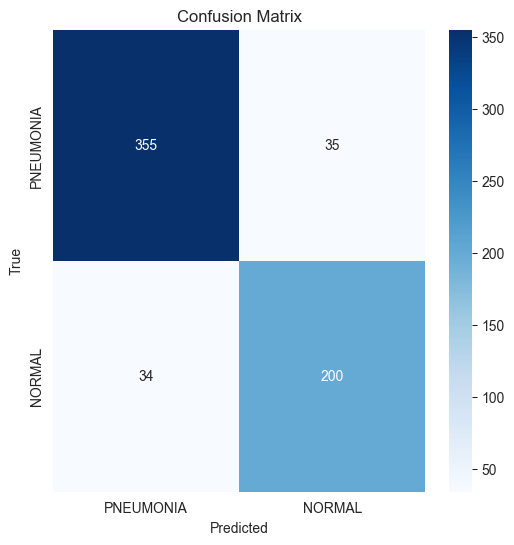

In [112]:
cm = confusion_matrix(y_test, pred_labels)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [113]:
# ✅ Save the model
model.save("pneumonia_cnn_model.h5")
print("✅ Model saved as pneumonia_cnn_model.h5")


✅ Model saved as pneumonia_cnn_model.h5
